In [1]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
clist = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
         '#ffff33', '#a65628', '#f781bf', '#999999']
prop_cycle = pl.cycler(color=clist)
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

In [2]:
# Load and preprocess data
td = pd.read_csv('data/temples.csv')

########## data cleanup ###############
# clean up column names to be more self-explanatory
column_changes = {'Site(ac)': 'site', u'Area(sq\u00A0ft)':'area', 'High(ft)':'height',
                  'Rms(1)':'ordinance rooms', 'Rms(2)':'sealing rooms',
                  'Center(3)':"Visitor's center", 'Food(4)':'Cafeteria'}
td = td.rename(columns=column_changes)

#   - get numbers out of the status
#   - remove "edit" string that appears at the end of many of the names
#   - remove footnotes from various date and related fields
footnote_regex = '\[[0-9]*\]'
fn = {footnote_regex:''} # the footnote removal dict
td = td.replace({'Name': {' *edit$':''},
                 'Status': {'^[0-9]*':''},
                 'area': {'TBD':np.nan},
                 'Groundbreaking': {'(No formal groundbreaking|'+footnote_regex+')':''},
                 'Groundbreakingby': fn,
                 'Dedication': {'(TBD|'+footnote_regex+')':''},
                 'Dedicationby': fn,
                 'Style': fn,
                 'Designer': fn}, regex=True)

# import dates into datetime format
dt_cols = ['Announcement', 'Groundbreaking', 'Dedication']
for col in dt_cols:
    td[col] = pd.to_datetime(td[col])

td['area'] = td['area'].astype(float)

# Get rid of NaN values in Style
td.loc[td['Style'].isna(), 'Style'] = ''

# area is missing for Lima Peru
# temples from the same era with similar architectural style and same number of rooms
# range from 11000 to 30000. Closest comps are likely Manila (26000) and
# Buenos Aires (30000), so use the average of those two. Both are on sites that
# are approximately 3.5 acres.
td.loc[td[td['Name']=='Lima Peru Temple'].index, 'area'] = 28000
td.loc[td[td['Name']=='Lima Peru Temple'].index, 'site'] = 3.5

# deal with cases where no groundbreaking is listed, because groundbreaking date is used later
missing_gr = td['Groundbreaking'].isna() & ~td['Dedication'].isna()
td.loc[missing_gr, 'Groundbreaking'] = td[missing_gr]['Dedication'] - np.timedelta64(3, 'Y')

# for this analysis, exclude temple temples that won't be built
exclude = ['Efforts halted in 1830s', 'Efforts suspended in 2006', 'Historic site', 'Destroyed']
td = td[~td['Status'].isin(exclude)]

In [3]:
most_common_size_count = td.value_counts('area').iloc[0]

# Area categories
td['area_cat'] = ''
td.loc[td['area']>0, 'area_cat'] = '0-12000'
td.loc[td['area']>12000, 'area_cat'] = '12000-20000'
td.loc[td['area']>20000, 'area_cat'] = '20000-30000'
td.loc[td['area']>30000, 'area_cat'] = '30000-40000'
td.loc[td['area']>40000, 'area_cat'] = '40000-50000'
td.loc[td['area']>50000, 'area_cat'] = '50000-70000'
td.loc[td['area']>70000, 'area_cat'] = '70000-100000'
td.loc[td['area']>100000, 'area_cat'] = '100000+'

# Dedication decade
td['ded_dec'] = 'future'
td.loc[td['Dedication'].dt.year>0, 'ded_dec'] = 'earlier'
td.loc[td['Dedication'].dt.year>=1980, 'ded_dec'] = '1980s'
td.loc[td['Dedication'].dt.year>=1990, 'ded_dec'] = '1990s'
td.loc[td['Dedication'].dt.year>=2000, 'ded_dec'] = '2000s'
td.loc[td['Dedication'].dt.year>=2010, 'ded_dec'] = '2010s'
td.loc[td['Dedication'].dt.year>=2020, 'ded_dec'] = '2020s'

# region categories
td['reg_cat'] = 'non-US'
td.loc[td['Country']=='United States', 'reg_cat'] = 'other US'
td.loc[td['Region'].isin(['Utah', 'Idaho', 'Arizona']), 'reg_cat'] = 'UT/ID/AZ'

#td['area_cat'].value_counts().sort_index()
#td.value_counts('ded_dec').sort_index()
#td['reg2'].value_counts()

In [4]:
# For projecting future costs, estimate sizes of announced temples. Small, medium, and large
# temples are assigned to be 10,000, 20,000, and 30,000 square feet. Most of the temples are
# presumed to be small, including all of those in Europe and Asia. A few are presumed medium
# based on being near large population centers in countries with large church membership.
small_temple_list = [
    'Managua Nicaragua Temple',
    'Budapest Hungary Temple',
    'Dubai United Arab Emirates Temple',
    'Oslo Norway Temple',
    'Brussels Belgium Temple',
    'Vienna Austria Temple',
    'Cape Town South Africa Temple',
    'Singapore Republic of Singapore Temple',
    'Kaohsiung Taiwan Temple',
    'Tacloban City Philippines Temple',
    'Cagayan de Oro Philippines Temple',
    'Urdaneta Philippines Temple',
    'Alabang Philippines Temple',
    'Cody Wyoming Temple',
    'Culiacán Mexico Temple',
    'Querétaro Mexico Temple',
    'Vitória Brazil Temple',
    'Belém Brazil Temple',
    'Antananarivo Madagascar Temple',
    'Santa Cruz Bolivia Temple',
    'Lagos Nigeria Temple',
    'Freetown Sierra Leone Temple',
    'Bahía Blanca Argentina Temple',
    'Benin City Nigeria Temple',
    'Kumasi Ghana Temple',
    'Beira Mozambique Temple',
    'Monrovia Liberia Temple',
    'Nairobi Kenya Temple',
    'Abidjan Ivory Coast Temple',
    'San Juan Puerto Rico Temple',
    'Lubumbashi Democratic Republic of the Congo Temple',
    'Kananga Democratic Republic of the Congo Temple',
    'Auckland New Zealand Temple'
]

medium_temple_list = [
    'Quito Ecuador Temple',
    'Lima Peru Los Olivos Temple',
    'Salta Argentina Temple',
    'Salvador Brazil Temple',
    'São Paulo East Brazil Temple',
    'Santiago West Chile Temple',
    'Fort Worth Texas Temple',    
    'Rexburg North Idaho Temple']

large_temple_list = [
    'Rio de Janeiro Brazil Temple',
    'La Paz Bolivia Temple']

even_larger_list = ['Heber Valley Utah Temple']

who_knows_if_it_will_get_built_list = [
    'Russia Temple',
    "Shanghai People's Republic of China Temple"]

td.loc[td['Name'].isin(small_temple_list), 'area'] = 10000
td.loc[td['Name'].isin(medium_temple_list), 'area'] = 20000
td.loc[td['Name'].isin(large_temple_list), 'area'] = 30000
td.loc[td['Name'].isin(even_larger_list), 'area'] = 40000

td['area_estimated'] = 0
td.loc[td['Name'].isin(small_temple_list+medium_temple_list+large_temple_list), 'estimated_area'] = 1

# estimate site size for temples that don't have lots yet.
# based on previous averages, small:3 acres, medium: 6 acres, large: 10 acres
lot_dict = {10000:3, 20000:6, 30000:10, 40000:10}
site_idx = (td['site']==0) & ~td['area'].isna()

td[site_idx][['Name', 'area', 'Announcement']]
td['site_estimated'] = 0
td.loc[site_idx, 'site_estimated'] = 1

td.loc[site_idx, 'site'] = td[site_idx]['area'].replace(lot_dict)

# Analysis of data on the temples
The following is some analysis of the temple data found on this [Wikipedia page](https://en.wikipedia.org/wiki/Comparison_of_temples_of_The_Church_of_Jesus_Christ_of_Latter-day_Saints). The data were extracted into a table using this [online tool](https://wikitable2csv.ggor.de/).

## Temple construction time
The chart below illustrates the rate at which temples are started and completed after they are announced. As of 2021, the most recent year for which all temples announced in that year have been completed is 2012, and the most recent year for which all announced temples have been started is 2017. These data points suggest that there can be a delay of up to 4 years to groundbreaking from announcement, and another 5 years to dedication after groundbreaking. The average times for these are a little less than that, but more than 3 years in both cases. On the other hand, ground has already been broken on a handful of temples announced in both 2020 and 2021.

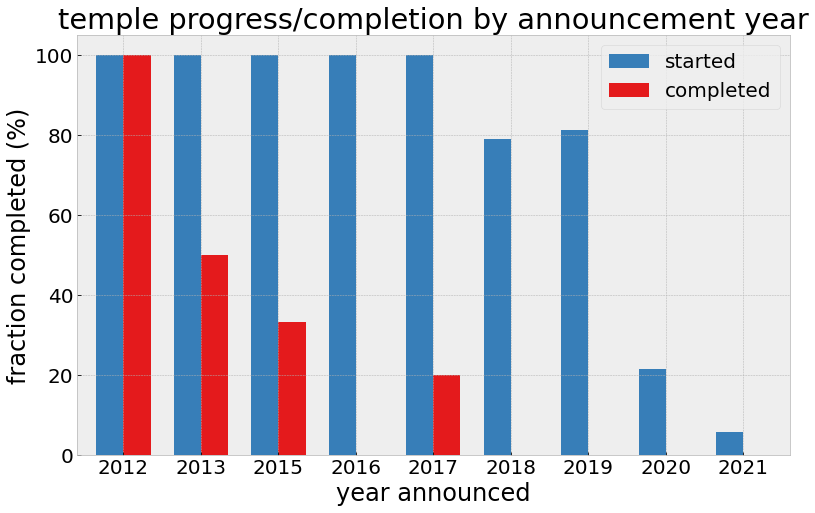

In [5]:
an_cmpl = td['Announcement'].dt.year.to_frame('year announced').assign(
    started=(~td['Groundbreaking'].isna()).astype(int).to_frame('started'),
    completed=(~td['Dedication'].isna()).astype(int).to_frame('completed'))

plotdata = an_cmpl.groupby('year announced').mean()
ax = (plotdata[plotdata.index>=2012]*100).plot.bar(rot=0, width=0.7, ylabel='fraction completed (%)',
                                                   title='temple progress/completion by announcement year')

In [6]:
# Use temples completed since 2008 as a reference for estimating planning and construction time
# set minimum date for estimated grounbreaking and dedication so they aren't in the past
min_date = pd.to_datetime('2022-07-01')

ref_temples = td[(td['Announcement'].dt.year>=2008) & (~td['Dedication'].isna())]
est_times = ref_temples[['Announcement', 'Groundbreaking', 'Dedication']].diff(axis=1).mean()

gr_est = td['Groundbreaking'].isna()
td.loc[gr_est, 'Groundbreaking'] = td[gr_est]['Announcement'] + est_times['Groundbreaking']
idx = gr_est & (td['Groundbreaking'] < min_date)
td.loc[idx, 'Groundbreaking'] = min_date

de_est = td['Dedication'].isna()
td.loc[de_est, 'Dedication'] = td[de_est]['Groundbreaking'] + est_times['Dedication']
idx = de_est & (td['Dedication'] < min_date)
td.loc[idx, 'Dedication'] = min_date

td['completion_estimated'] = 0
td.loc[de_est, 'completion_estimated'] = 1

## Size of temples over time
The chart below shows the size (in square feet) of every temple built since 1950. The largest, Los Angeles, at over 190,000 square feet is by far the largest temple built since its completion. Only the Salt Lake temple is larger (250,000 square feet), but it includes a good deal of space that is not used as a temple in the way that the others are.

The pattern over time has been a steady decline in size of temples, even well before the advent of the "mini temple" that was built in large numbers starting in 1998. Only a handful of temples larger than 100,000 square feet have ever been built, with the most recent one Mt. Timpanogos in the 1990s. The most common size of a temple is 10,700 square feet, based on a design introduced in 1998 and still used frequently to this day. At this time a total of 32 temples are this size. For comparison, a typical church meetinghouse in North America is around 15,000 square feet. Almost no temples larger than 40,000 square feet have been built outside the mountain west (Utah, Idaho, and Arizona) in the last 20 years. So, while the number of new temples announced has increased substantially in the last few years, particularly since Russell M. Nelson became president of the church, most of them are much smaller than the temples of the past. This detail is significant when examining how much the temple building program might cost.

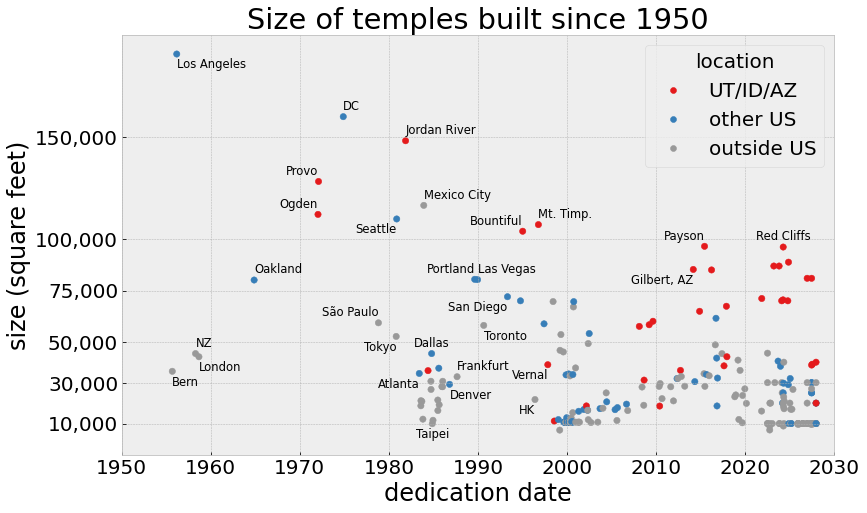

In [7]:
# Original version of code using pandas plotting functions.
# I can't get the legend to work correctly with this one,
# so I'm using matplotlib calls directly (see below).
#
#cdict = {'UT/ID/AZ': clist[1], 'other US': clist[0], 'non-US': clist[8]}
#ax = td.plot.scatter('Dedication', 'area',
#                c=[cdict[r] for r in td['reg_cat']],
#                s=40,
#                logy=False,
#                legend=True,
#                ylabel='size (square feet)',
#                xlabel='dedication date',
#                xlim=[pd.to_datetime('1950-01-01'), pd.to_datetime('2029-01-01')],
#                title='Temples by size and dedication date')
#pl.yticks([1e4,3e4,5e4,1e5], ['10,000', '30,000', '50,000', '100,000'])
#pl.legend(cdict.keys())

from matplotlib.colors import ListedColormap
cmap = ListedColormap([clist[1], clist[0], clist[8]])

td_ = td[~td['area'].isna()]
idict = {'UT/ID/AZ': 0, 'other US': 1, 'non-US': 2}
idx = np.array([idict[r] for r in td_['reg_cat']])

sc = pl.scatter(td_['Dedication'], td_['area'], c=idx, cmap=cmap, s=40)
pl.yticks([1e4,3e4,5e4,7.5e4,1e5,1.5e5], ['10,000', '30,000', '50,000', '75,000', '100,000', '150,000'])
pl.ylabel('size (square feet)')
pl.xlabel('dedication date')
pl.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2030-01-01')])
pl.ylim(ymax=200000)
pl.title('Size of temples built since 1950')
_ = pl.legend(sc.legend_elements()[0], ['UT/ID/AZ', 'other US', 'outside US'], title='location')

# Annotations
if True:
    labeldata = [
        ('Los Angeles California Temple', 'Los Angeles', 'left', 'top'),
        ('Bern Switzerland Temple', 'Bern', 'left', 'top'),
        ('London England Temple', 'London', 'left', 'top'),
        ('Hamilton New Zealand Temple', 'NZ', 'left', 'bottom'),
        ('Oakland California Temple', 'Oakland', 'left', 'bottom'),
        ('Jordan River Utah Temple', 'Jordan River', 'left', 'bottom'),
        ('Provo Utah Temple', 'Provo', 'right', 'bottom'),
        ('Ogden Utah Temple', 'Ogden', 'right', 'bottom'),
        ('Washington D.C. Temple', 'DC', 'left', 'bottom'),
        ('Bountiful Utah Temple', 'Bountiful', 'right', 'bottom'),
        ('Mount Timpanogos Utah Temple', 'Mt. Timp.', 'left', 'bottom'),
        ('Payson Utah Temple', 'Payson', 'right', 'bottom'),
        ('Red Cliffs Utah Temple', 'Red Cliffs', 'center', 'bottom'),
        ('Mexico City Mexico Temple', 'Mexico City', 'left', 'bottom'),
        ('Seattle Washington Temple', 'Seattle', 'right', 'top'),
        ('Dallas Texas Temple', 'Dallas', 'center', 'bottom'),
        ('Atlanta Georgia Temple', 'Atlanta', 'right', 'top'),
        ('Denver Colorado Temple', 'Denver', 'left', 'top'),
        ('Frankfurt Germany Temple', 'Frankfurt', 'left', 'bottom'),
        ('Portland Oregon Temple', 'Portland', 'right', 'bottom'),
        ('Las Vegas Nevada Temple', 'Las Vegas', 'left', 'bottom'),
        ('São Paulo Brazil Temple', 'São Paulo', 'right', 'bottom'),
        ('Tokyo Japan Temple', 'Tokyo', 'right', 'top'),
        ('Taipei Taiwan Temple', 'Taipei', 'center', 'top'),
        ('Toronto Ontario Temple', 'Toronto', 'left', 'top'),
        ('Vernal Utah Temple', 'Vernal', 'right', 'top'),
        ('San Diego California Temple', 'San Diego', 'right', 'top'),
        ('Hong Kong China Temple', 'HK', 'right', 'top'),
        ('Gilbert Arizona Temple', 'Gilbert, AZ', 'right', 'top')]

    ax = pl.gca()
    for label, shortlabel, halign, valign in labeldata:
        data = td_[td_['Name']==label][['Dedication', 'area']].iloc[0].copy()
        if valign=='top':
            data['area'] -= 2000
        else:
            data['area'] += 2000
        ax.annotate(shortlabel, data, size='xx-small', ha=halign, va=valign)

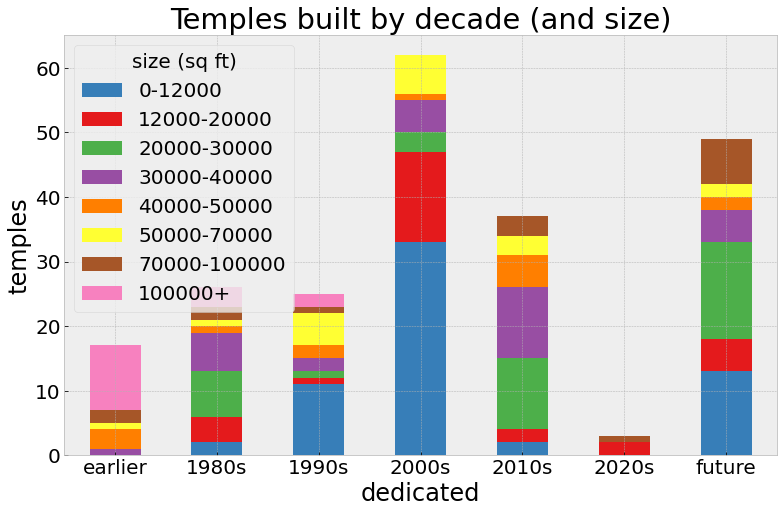

In [8]:
ded_size_table = td.groupby(['area_cat', 'ded_dec']).size().reset_index().pivot(
    columns='area_cat', index='ded_dec').fillna(0)
ded_size_table = ded_size_table.loc[
    ['earlier', '1980s', '1990s', '2000s', '2010s', '2020s', 'future']]
ded_size_table.columns = ded_size_table.columns.get_level_values(1)
ded_size_table = ded_size_table[
    ['0-12000', '12000-20000', '20000-30000', '30000-40000',
     '40000-50000', '50000-70000', '70000-100000', '100000+']]
ded_size_table.columns.name = 'size (sq ft)'
_ = ded_size_table.plot.bar(stacked=True, rot=0,
                            ylabel='temples', xlabel='dedicated',
                            title='Temples built by decade (and size)')

## Construction cost
In order to estimate construction costs of the temple building program, the primary reference points are the size of the structure in square feet, and the size of the land. In quite a few cases for the most recently announced temples, these data points are missing, so they must be filled in with educated guesses in order to get the most realistic cost estimate.

Guessing temple and lot sizes was done with the following assumptions:
 - nearly all temples outside the US, particularly Africa and Asia, are assumed to be 10,000 square feet, based on construction patterns in those regions in the last 20 years.
 - a handful of temples were assumed to be slightly larger, either 20,000 or 30,000 square feet if they were near large population centers in countries with relatively large numbers of church members, based on typical sizes of existing temples in those countries. This includes several temples in various South American countries. Fort Worth, Texas and Rexburg North, Idaho were also put in this mid-size category due to their relative proximity to existing temples.
 - The Heber Valley, Utah temple was assumed to be 40,000 square feet based on sizes of temples in other parts of Utah with similar population.
 - Announced temples in Russia and China have been omitted due to ongoing uncertainty over whether they are likely to be built any time soon.
 - Land sizes were set at 3, 6, or 10 acres depending on the temple size, in line with patterns in the data for existing temples.

The two key assumptions for computing costs were a land price of US \\$500,000 per acre. This one is a bit of a wild guess, and turns out to be a not particularly consequential portion of the overall cost. The key value is the construction cost per square foot. In the US, commercial construction costs can run a few hundred up to \\$1000 per square foot. Temples are typically built to a relatively high grade, so we choose the high end of that range at \\$1000. We assume that the church is paying for construction directly without borrowing, and that the construction costs are amortized roughly equally over the construction period. If groundbreaking was 2012 and dedication in 2015, the cost per square foot is divided by 4 and allocated to the years 2012, 2013, 2014, and 2015. This is all very rough, but tends to average out any estimation errors with the larger volume of construction projects during the last 20 years.

A great many projects have been announced in the last few years and not been completed or in some cases even started. In order to project future costs, for those cases the average time to groundbreaking and from groundbreaking to construction for temples completed in the last 20 years have been used to compute placeholder start and completion dates. This puts the completion of some of the temples announed in 2021 into 2027 and 2028.

The results of these calculations are shown in the chart below. By applying the same cost assumptions over time, we are effectively calculating costs in inflation-adjusted 2021 dollars. From these results we can see that most of the time from about 1980 to the present, the annual expenditure was between US \\$100 million and \\$200 million in most years, with the exception of the mini-temple construction surge in 1998-1999, and a new similar surge that began last year. In both cases those surges of construction led to expenditures in the \\$300-400 million range. The current construction boom is signficant, but because so many of the new temples are likely to be the very small ones, the total annual expenditure is in line with the last construction boom, though it is likely to stay high for several more years.

In [9]:
# costs are per square foot and per acre
construction_cost = 1000
land_cost = 500000

date_info = td[~td['Dedication'].isna() & ~td['Groundbreaking'].isna() &
               (td['Dedication']>pd.to_datetime('1950-01-01'))][
    ['Groundbreaking', 'Dedication', 'area', 'site', 'completion_estimated', 'site_estimated']]
date_info['land_purchase'] = date_info['Groundbreaking'].dt.year - 1

date_info['years'] = date_info.apply(lambda x: range(x['Groundbreaking'].year, x['Dedication'].year+1), axis=1)
date_info['area_amortized'] = date_info['area'] / date_info['years'].str.len()

years = date_info.explode('years')[['years', 'area_amortized', 'completion_estimated']]

yearly_total_ = years.groupby(['years', 'completion_estimated']).sum().reset_index().pivot(
    index='years', columns='completion_estimated').fillna(0)
yearly_total_.columns = ['area_amortized', 'area_amortized_est']
# old version
#yearly_total_ = years.groupby('years').sum()
# create array with full set of indices so that empty years will be present
yearly_total = pd.Series(index=range(1950,2029), dtype='float64').to_frame('x').join(
    yearly_total_).drop(columns='x').fillna(0)

land_acres = date_info[['land_purchase', 'site', 'site_estimated']].groupby(
    ['land_purchase', 'site_estimated']).sum().reset_index().pivot(
    index='land_purchase', columns='site_estimated').fillna(0)
land_acres.columns = ['land', 'land_est']
#land_acres = date_info[['land_purchase', 'site']].groupby('land_purchase').sum().rename(columns={'site':'land'})
yearly_total = yearly_total.join(land_acres).fillna(0)

yearly_total['land cost'] = yearly_total['land']*land_cost
yearly_total['land cost (projected)'] = yearly_total['land_est']*land_cost
yearly_total['construction cost'] = yearly_total['area_amortized']*construction_cost
yearly_total['construction cost (projected)'] = yearly_total['area_amortized_est']*construction_cost
yearly_total['total cost'] = yearly_total[['land cost', 'land cost (projected)',
                                           'construction cost', 'construction cost (projected)']].sum(1)

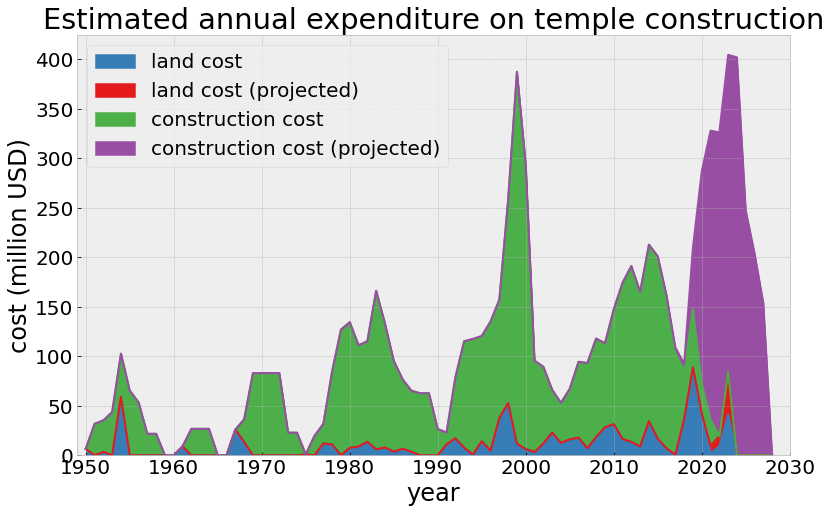

In [10]:
# stacked area graph of the 4 components of the total
ax = (yearly_total[['land cost', 'land cost (projected)',
                    'construction cost', 'construction cost (projected)']]/1e6).plot.area(
    title='Estimated annual expenditure on temple construction',
    stacked=True,
    ylabel='cost (million USD)',
    xlabel='year',
    xlim=[1949, 2030],
    ylim=[0, None])

To compare this total to the church's annual operating costs (in 2021 dollars), we use $7 billion as an estimate of the operating costs of the church. At that number, temple construction has been about 2-3\% of annual operating costs since 2000, but briefly went as high as 5\% in 1999 and appears likely to do so again in the coming years with the recent surge of announcements.

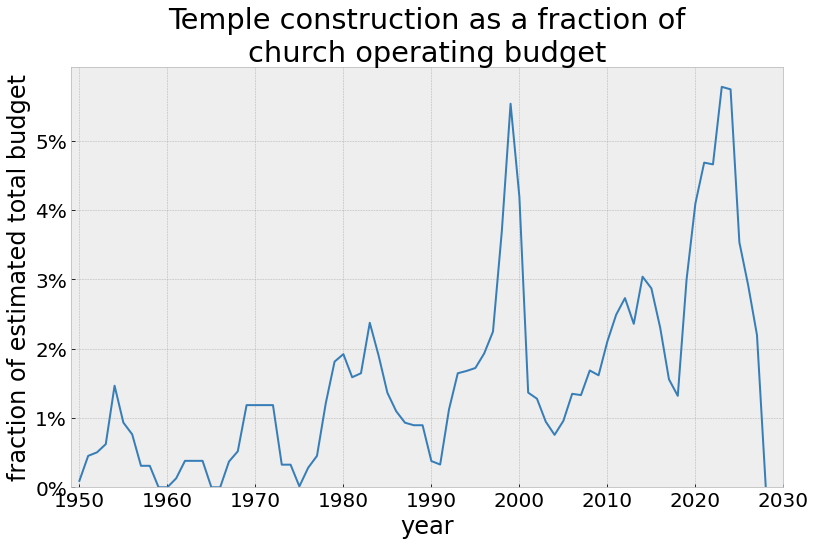

In [11]:
(yearly_total['total cost']/7e9*100).plot(
    title='Temple construction as a fraction of\nchurch operating budget',
    xlabel='year',
    ylabel='fraction of estimated total budget',
    ylim=[0, None],
    xlim=[1949, 2030])
yt = range(0, 6)
_ = pl.yticks(yt, [str(x)+'%' for x in yt])

In [12]:
# temples with groundbreaking less than a year after announcement
#td[(td['Groundbreaking']-td['Announcement']).dt.days<365][['Name', 'Announcement', 'Groundbreaking']]
#['Announcement'].dt.year.value_counts()

In [13]:
# scatter plots of size vs. planning & contstruction times

#td['planning_years'] = (td['Groundbreaking']-td['Announcement']).dt.days/365
#td['construction_years'] = (td['Dedication']-td['Groundbreaking']).dt.days/365
#td.plot.scatter('construction_years', 'area', xlim=[0, 10], logy=True)
#td.plot.scatter('planning_years', 'area', xlim=[0, 10], logy=True)

In [14]:
# ann_area = td['Announcement'].dt.year.to_frame('announce_year').join(
#     td['area']).groupby('announce_year')

# year_stats = ann_area.size().to_frame('number').join(ann_area.sum())

# ax = year_stats.plot(
#     secondary_y=['area'],
#     title='number of temples and total size of temples\nby year of announcement',
#     ylabel='temples',
#     xlabel='year announced',
#     xlim=[1970,2025])
# ax.right_ax.set_ylabel('total area (sq ft)')

In [15]:
#ann_year_means = td['Announcement'].dt.year.to_frame('announce_year').join(
#    td['area']).groupby('announce_year').mean()
#all_year_means = pd.Series(index=range(1980,2025), dtype='float64').to_frame('x').join(
#    mean_ann_year_area).drop(columns='x')
#all_year_means.plot(title='mean size of temples announce by year',
#                    ylim=[0,None])

In [16]:
#td.groupby('area_cat')['site'].mean()

In [17]:
#td[td['site']==0][['Name', 'Announcement', 'area']]

In [18]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')